In [53]:
#mount google drive when on google colaboratory

from google.colab import drive
drive.mount('/content/drive')

#set repo path and check repo status
repo_path = '/content/drive/MyDrive/shape-recognition/'
%cd /content/drive/MyDrive/shape-recognition/
!git status


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/shape-recognition
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   data.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [1]:
#initialize environment, load modules/libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mppatch
import xml.etree.ElementTree as ET

#import python code from seperate files
from utils.generators import gen_shapes, gen_lines, gen_ellipses, gen_image, gen_details
from utils.helpers import gen_grid_image

rnd=np.random.default_rng(31)


In [2]:
folder=["train","validate","test"] 
num_images={"train":10, "validate":3, "test":3}

num_shapes=50
max_radius=1/20
min_radius=1/40

num_lines=500
max_len=1/10
min_len=1/80

num_ellipses=200
max_diam=1/10
min_diam=1/80

im_size=1024
max_lw=0.5
min_lw=0.1
min_gray=0.7

radius = int(max_radius*im_size)+1
detail_im_size = 2*radius+1

fluct=0

In [3]:
#generate random figures and noise and save in npz

for name in folder:
    for i in range(num_images[name]):
        sha = gen_shapes(rnd, num_shapes, max_radius, min_radius, False, False)
        lns = gen_lines(rnd, num_lines, max_len, min_len)
        eps = gen_ellipses(rnd, num_ellipses, max_diam, min_diam)

        target = name+"/"+name+f"{i:04d}"
        np.savez_compressed("data/raw/"+target+".npz", shapes=sha, lines=lns, ellipses=eps)

    plt.close()

In [4]:
#generate image data and save in npz

for name in folder:
    for i in range(num_images[name]):
        source = name+"/"+name+f"{i:04d}"
        loaded  = np.load("data/raw/"+source+".npz")
        shapes = loaded['shapes']
        lines = loaded['lines']
        ellipses = loaded['ellipses']
        img, sha, lns, eps, box = gen_image(shapes, lines, ellipses, im_size, max_lw, min_lw, min_gray, False)
        focus = gen_details(detail_im_size, sha, img, rnd, fluct)

        target = name+"/"+name+f"{i:04d}"
        np.savez_compressed("data/"+target+".npz", image=img, shapes=sha, lines=lns, ellipses=eps, details=focus, boxes=box)

    plt.close()

In [5]:
#plot image data and save in jpg 

for name in folder:
    for i in range(num_images[name]):
        source = name+"/"+name+f"{i:04d}"
        loaded  = np.load("data/"+source+".npz")
        image = loaded['image']
        shapes = loaded['shapes']
        details = loaded['details']
        boxes = loaded['boxes']

        fig = plt.figure(figsize=(image.shape[1],image.shape[0]),dpi=1)
        fig.figimage(image, cmap='gray')
        fig.savefig("data/"+source+".jpg")
        plt.close()


In [6]:
#generate box labels and save in xml

for name in folder:
    for i in range(num_images[name]):
        filename = name+f"{i:04d}"
        source = name+"/"+ filename
        loaded  = np.load("data/"+source+".npz")
        shapes = loaded['shapes']
        boxes = loaded['boxes']

        annotation=ET.Element('annotation')
        ET.SubElement(annotation,'folder')
        ET.SubElement(annotation,'filename').text=filename+".jpg"
        ET.SubElement(annotation,'path').text=filename+".jpg"
        ET.SubElement(annotation,'source').text='synthetic'
        ET.SubElement(annotation,'segmented').text='0'
        size=ET.SubElement(annotation,'size')
        ET.SubElement(size,'width').text=f"{im_size}"
        ET.SubElement(size,'height').text=f"{im_size}"
        ET.SubElement(size,'depth').text='1'

        for k in range(num_shapes):
          obj=ET.SubElement(annotation,'object')
          ET.SubElement(obj,'name').text=f"{int(shapes[k][0])}"
          ET.SubElement(obj,'pose').text='Unspecified'
          ET.SubElement(obj,'truncated').text='0'
          ET.SubElement(obj,'difficult').text='0'
          ET.SubElement(obj,'occluded').text='0'
          box=ET.SubElement(obj,'bndbox')
          ET.SubElement(box,'xmin').text=f"{int(boxes[k][0]+0.5)}"
          ET.SubElement(box,'xmax').text=f"{int(boxes[k][1]+0.5)}"
          ET.SubElement(box,'ymin').text=f"{im_size-int(boxes[k][3]+0.5)}"
          ET.SubElement(box,'ymax').text=f"{im_size-int(boxes[k][2]+0.5)}"

        ET.ElementTree(annotation).write("data/"+source+".xml")

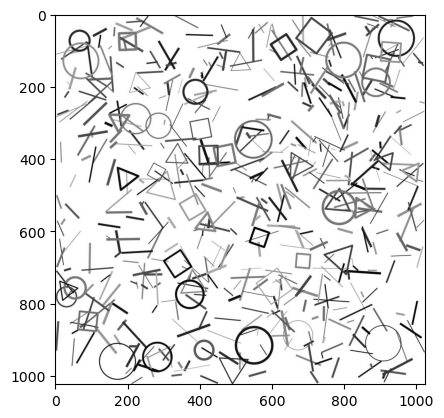

In [7]:
name=folder[0]
source = name+"/"+name+f"{0:04d}"

plt.imshow(mpimg.imread("data/"+source+".jpg"))
#plt.gca().add_patch(mppatch.Rectangle((348,831),97,96,linewidth=1,edgecolor='g',facecolor='none'))

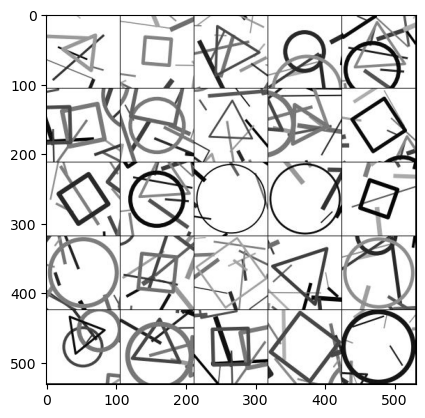

In [8]:
loaded  = np.load("data/"+source+".npz")
details = loaded['details']

grid = (5,5)
grid_image, grid_pos = gen_grid_image(details, grid)

fig = plt.figure(figsize=(grid_image.shape[1],grid_image.shape[0]),dpi=1)
fig.figimage(grid_image, cmap='gray')
fig.savefig('data/tmp_grid.jpg')
plt.close()

plt.imshow(mpimg.imread('data/tmp_grid.jpg'))

In [9]:
shapes = loaded['shapes']

print("\nposition : shape : [pos_x, pos_y, size, rotation, line_width, gray]")
np.set_printoptions(precision=3, suppress=True)
for i in range(grid[0]*grid[1]):
    print(f"{grid_pos[i]} : {int(shapes[i][0])} {shapes[i][1:]}")


position : shape : [pos_x, pos_y, size, rotation, line_width, gray]
(0, 0) : 3 [989.37  587.015  29.232   1.451   0.376   0.854]
(0, 1) : 4 [686.627 340.638  26.644   0.704   0.351   0.734]
(0, 2) : 3 [673.202 604.254  41.08    0.489   0.257   0.418]
(0, 3) : 2 [ 68.085 950.143  27.741   0.      0.417   0.222]
(0, 4) : 3 [382.882 274.745  41.445   0.065   0.27    0.754]
(1, 0) : 4 [469.619 633.414  36.56    0.986   0.446   0.675]
(1, 1) : 2 [888.406 835.028  38.453   0.      0.38    0.682]
(1, 2) : 3 [337.917 630.319  35.581   2.052   0.193   0.42 ]
(1, 3) : 3 [848.7   486.845  32.298   0.474   0.39    0.666]
(1, 4) : 4 [339.474 332.791  38.941   1.364   0.364   0.058]
(2, 0) : 4 [632.837 932.549  36.259   1.368   0.46    0.223]
(2, 1) : 2 [373.117 248.16   38.194   0.      0.408   0.064]
(2, 2) : 2 [908.623 112.858  49.156   0.      0.127   0.013]
(2, 3) : 2 [172.877  62.707  49.798   0.      0.196   0.085]
(2, 4) : 4 [565.625 405.827  29.818   0.455   0.403   0.035]
(3, 0) : 2 [798.

In [10]:
boxes = loaded['boxes']

print("\nposition : [x_min, x_max, y_min, y_max]")
np.set_printoptions(precision=3, suppress=True)
for i in range(grid[0]*grid[1]):
    print(f"{grid_pos[i]} : {boxes[i]}")


position : [x_min, x_max, y_min, y_max]
(0, 0) : [ 960.347 1006.905  560.135  610.404]
(0, 1) : [666.313 706.941 320.324 360.952]
(0, 2) : [651.431 714.257 569.417 640.527]
(0, 3) : [ 40.344  95.826 922.401 977.884]
(0, 4) : [348.42  420.051 251.723 316.101]
(1, 0) : [439.132 500.106 602.927 663.901]
(1, 1) : [849.953 926.859 796.575 873.481]
(1, 2) : [306.375 367.947 611.236 665.868]
(1, 3) : [831.19  880.959 459.705 515.579]
(1, 4) : [301.36  377.588 294.677 370.905]
(2, 0) : [597.317 668.357 897.03  968.069]
(2, 1) : [334.923 411.311 209.966 286.354]
(2, 2) : [859.467 957.78   63.702 162.015]
(2, 3) : [123.079 222.675  12.909 112.505]
(2, 4) : [538.845 592.405 379.047 432.607]
(3, 0) : [750.681 846.61  848.873 944.802]
(3, 1) : [ 63.391 118.477 146.13  201.215]
(3, 2) : [556.974 656.938 220.573 320.538]
(3, 3) : [745.41  822.972 303.447 383.3  ]
(3, 4) : [ 22.951 120.375 845.664 943.087]
(4, 0) : [  4.544  59.549 213.716 268.722]
(4, 1) : [748.112 816.133 479.094 540.873]
(4, 2) : 